In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from functools import partial
import numba as nb

In [138]:
content = pd.read_csv('./gene_pathway_matrix.csv')
pathway_names = content[content.columns[0]]
gene_names = content.columns[1:]
only_data = content.drop(columns=[content.columns[0]])
matrix = np.ascontiguousarray(only_data.values.T)

In [9]:
@nb.njit()
def evaluate_cut(matrix, labeling, c):
    value = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if labeling[i] != labeling[j + matrix.shape[0]]:
                if matrix[i, j]:
                    value += 1
                else:
                    value += c
    return value
            
def create_random_labeling(matrix, threshold):
    N = np.sum(matrix.shape)
    num_clusters = np.ceil(N / threshold)
    new_threshold = N / num_clusters
    labeling = (np.arange(N) / new_threshold).astype('int')
    np.random.shuffle(labeling)
    return labeling

In [61]:
@nb.njit()
def get_cost(matrix, i, j, c):
    if j < i:
        i, j = j, i
    if i >= matrix.shape[0]:
        return 0
    if j < matrix.shape[0]:
        return 0
    
    j -= matrix.shape[0]
    
    return max(matrix[i, j], c)

@nb.njit()
def cost_to_other(matrix, source, others, c):
    costs = np.zeros_like(source)
    for i, a in enumerate(source):
        for b in others:
            costs[i] += get_cost(matrix, a, b, c)
    return costs

@nb.njit()
def get_cross_costs(matrix, A, B, c):
    result = np.zeros((len(A), len(B)))
    for i, a in enumerate(A):
        for j, b in enumerate(B):
            result[i, j] = get_cost(matrix, a, b, c)
    return result

@nb.njit()
def get_pairwise_improvements(matrix, labeling, a, b, c):
    nodes_a = np.where(labeling == a)[0]
    nodes_b = np.where(labeling == b)[0]
    internal_a = cost_to_other(matrix, nodes_a, nodes_a, c)
    internal_b = cost_to_other(matrix, nodes_b, nodes_b, c)
    ext_a_to_b = cost_to_other(matrix, nodes_a, nodes_b, c)
    ext_b_to_a = cost_to_other(matrix, nodes_b, nodes_a, c)
    D_a = ext_a_to_b - internal_a
    D_b = ext_b_to_a - internal_b
    cross_costs = get_cross_costs(matrix, nodes_a, nodes_b, c)
    all_improvements = np.zeros_like(cross_costs)
    for i in nb.prange(all_improvements.shape[0]):
        for j in range(all_improvements.shape[1]):
            all_improvements[i, j] = D_a[i] + D_b[j] - 2 * cross_costs[i , j]
    return all_improvements, nodes_a, nodes_b

@nb.njit()
def create_numba_int_list():
    l = List()
    l.append(32)
    l.pop()
    return l

@nb.njit()
def discard_done_swaps(all_improvements, done_a, done_b):
    for a in done_a:
        all_improvements[a, :] = -np.inf
    for b in done_b:
        all_improvements[:, b] = -np.inf

@nb.njit()
def kernighan_lin_step(matrix, labeling, cluster_1, cluster_2, c):
    temp_labeling = labeling.copy()
    
    A = np.where(labeling == cluster_1)[0]
    B = np.where(labeling == cluster_2)[0]
    
    done_a = []
    done_b = []
    
    g = 0
    gs = []
    swaps = []
    
    for _ in range(min(len(A), len(B))):
        all_improvements, A, B = get_pairwise_improvements(matrix, temp_labeling, cluster_1, cluster_2, c)
        discard_done_swaps(all_improvements, done_a, done_b)
        
        ix = np.argmax(all_improvements)
        a, b = ix // all_improvements.shape[1], ix % all_improvements.shape[1]
        done_a.append(a)
        done_b.append(b)
        ra = A[a]
        rb = B[b]
        
        swaps.append((ra, rb))
        g += all_improvements[a, b]
        gs.append(g)
        temp_labeling[ra], temp_labeling[rb] = temp_labeling[rb], temp_labeling[ra]
            
    num_steps = np.argmax(np.array(gs))
    if gs[num_steps] > 0:
        for i in range(num_steps + 1):
            ra, rb = swaps[i]
            labeling[ra], labeling[rb] = labeling[rb], labeling[ra]

        return gs[num_steps]
    else:
        return 0
    
@nb.njit()
def full_kl_step(matrix, labeling, c):
    num_clusters = len(set(labeling))
    order = np.random.permutation(num_clusters ** 2)
    
    impr = 0
    for o in order:
        cluster_1, cluster_2 = o // num_clusters, o % num_clusters
        impr += kernighan_lin_step(matrix, labeling, cluster_1, cluster_2, c)
    
    return impr
        
def kernighan_lin(matrix, labeling, c):
    tot = 0
    with tqdm() as p:
        while True:
            impr = full_kl_step(matrix, labeling, c)
            tot += impr
            p.set_postfix({
                'tot_impr': tot,
                'last_impr': impr,
                'loss': evaluate_cut(matrix, labeling, c)
            })
            p.update()
            if impr == 0:
                break
    return tot
    

In [87]:
def score_for_thres(matrix, thres):
    labeling = create_random_labeling(matrix, thres)
    kernighan_lin(matrix, labeling, c)
    return evaluate_cut(matrix, labeling, c), labeling
    

In [88]:
thresholds = np.array([25, 50, 100, 200, 500, 1000])
results = process_map(partial(score_for_thres, matrix), thresholds)

  0%|          | 0/6 [00:00<?, ?it/s]

6it [07:11, 72.00s/it, tot_impr=18749.0, last_impr=0, loss=69637]13]71]
7it [07:47, 66.81s/it, tot_impr=2.6e+4, last_impr=0, loss=62092]
9it [16:38, 110.95s/it, tot_impr=34610.0, last_impr=0, loss=52998] ]   
8it [31:44, 238.07s/it, tot_impr=41817.0, last_impr=0, loss=44741] 230]
8it [1:49:07, 818.40s/it, tot_impr=47687.0, last_impr=0, loss=35846] ]    
6it [2:47:24, 1674.11s/it, tot_impr=49154.0, last_impr=0, loss=29790] 


Text(0, 0.5, 'Cut size')

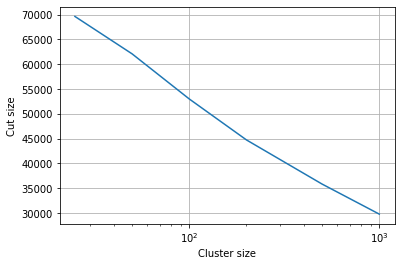

In [94]:
plt.plot(thresholds, [x[0] for x in results])
plt.xscale('log')
plt.grid()
plt.xlabel('Cluster size')
plt.ylabel('Cut size')

In [102]:
clusters = np.stack([x[1] for x in results])

In [128]:
frame = pd.DataFrame(clusters.T, columns=[f'cluster_{x}' for x in thresholds])

In [131]:
frame['is_gene'] = np.arange(clusters.shape[1]) < matrix.shape[0]

In [139]:
frame['description'] = np.concatenate([gene_names, pathway_names])

In [141]:
frame.to_csv('./kernighan_lin_clusters.csv')

In [100]:
gene = 608
i = 5
rel_pathways = np.where(matrix[gene])[0]
print(results[i][1][gene])
results[i][1][rel_pathways + matrix.shape[0]]

6


array([6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])